# Bank Marketing - Response Models

#### BANKING: DIRECT MARKETING CASE STUDY (CAMPAIGN RESPONSE MODEL) - CLASSIFICATION MODEL

**OBJECTIVE:** This example uses data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no').

### Importing Packages

In [112]:
import os
import numpy as np
import pandas as pd
import pandas_profiling
from scipy.stats import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics


from sklearn.feature_selection import RFE, SelectKBest, f_regression, f_oneway, f_classif

import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pickle

In [2]:
# Load the dataset
data = pd.read_csv('bank-additional.csv', sep=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [3]:
profile_report = pandas_profiling.ProfileReport(data)
profile_report

Number of variables,21
Number of observations,4119
Total Missing (%),0.0%
Total size in memory,675.9 KiB
Average record size in memory,168.0 B
Numeric,8
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


#### Exploratory Analysis

#### identifying relationships (between Y & numerical independent variables by comparing means)

In [4]:
data.y.value_counts()

no     3668
yes     451
Name: y, dtype: int64

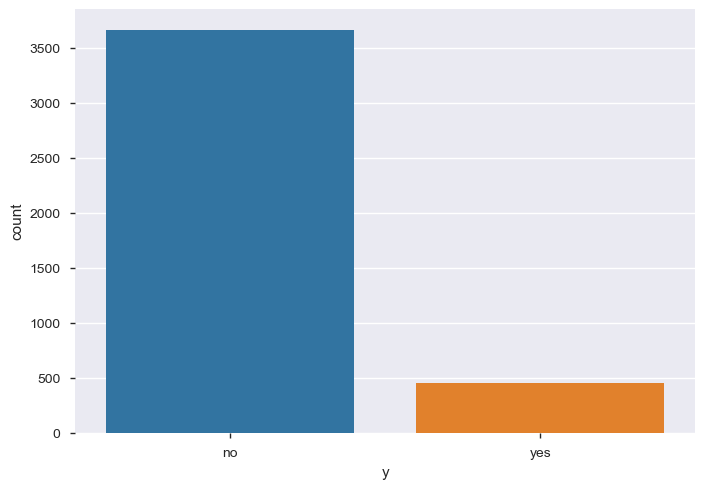

In [5]:
sns.countplot(x="y", data=data)
plt.show()

In [6]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
yes,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


##### Observations:
- The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
- The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
- Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

In [7]:
# Dropping the variables based on the data audit report (near zero variance, high missing, higly correlated variables, business logic)
data.drop(['euribor3m', 'nr.employed', 'default', 'pdays', 'cons.price.idx'], axis=1, inplace=True)

In [8]:
data.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.conf.idx', 'y'],
      dtype='object')

In [9]:
data.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.conf.idx,y
0,30,blue-collar,married,basic.9y,yes,no,cellular,may,fri,487,2,0,nonexistent,-1.8,-46.2,no
1,39,services,single,high.school,no,no,telephone,may,fri,346,4,0,nonexistent,1.1,-36.4,no
2,25,services,married,high.school,yes,no,telephone,jun,wed,227,1,0,nonexistent,1.4,-41.8,no
3,38,services,married,basic.9y,unknown,unknown,telephone,jun,fri,17,3,0,nonexistent,1.4,-41.8,no
4,47,admin.,married,university.degree,yes,no,cellular,nov,mon,58,1,0,nonexistent,-0.1,-42.0,no


In [10]:
#Renaming the columsns by replacing special characters with underscore
data.columns = [i.replace('.', '_') for i in data.columns]

In [11]:
#Missing value Treatment
data_cat = data.select_dtypes(include = 'O')
data_num = data.select_dtypes(exclude = 'O')

In [12]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=data_num.apply(lambda x: var_summary(x)).T

In [13]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,4119.0,0.0,165228.0,40.113620,38.0,10.313362,106.365426,18.0,24.0,26.0,28.8,32.0,38.0,47.0,55.0,58.0,68.00,88.0
duration,4119.0,0.0,1057710.0,256.788055,181.0,254.703736,64873.993194,0.0,11.0,35.0,60.0,103.0,181.0,317.0,545.2,740.2,1231.66,3643.0
campaign,4119.0,0.0,10451.0,2.537266,2.0,2.568159,6.595442,1.0,1.0,1.0,1.0,1.0,2.0,3.0,5.0,7.0,13.00,35.0
previous,4119.0,0.0,784.0,0.190337,0.0,0.541788,0.293535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.00,6.0
emp_var_rate,4119.0,0.0,350.0,0.084972,1.1,1.563114,2.443327,-3.4,-3.4,-2.9,-1.8,-1.8,1.1,1.4,1.4,1.4,1.40,1.4
cons_conf_idx,4119.0,0.0,-166815.8,-40.499102,-41.8,4.594578,21.110142,-50.8,-50.0,-47.1,-46.2,-42.7,-41.8,-36.4,-36.1,-33.6,-26.90,-26.9


In [14]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=data_cat.apply(cat_summary)

In [15]:
cat_summary

,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y
N,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
NMISS,0,0,0,0,0,0,0,0,0,0
ColumnsNames,admin. 1012 blue-collar 884 te...,married 2509 single 1153 divorced ...,university.degree 1264 high.school ...,yes 2175 no 1839 unknown 10...,no 3349 yes 665 unknown 10...,cellular 2652 telephone 1467 Name: cont...,may 1378 jul 711 aug 636 jun 53...,thu 860 mon 855 tue 841 wed 795 fr...,nonexistent 3523 failure 454 succes...,"no 3668 yes 451 Name: y, dtype: int64"


In [16]:
# Handling Missings & Outliers
def missing_cat(x):
    t = x.value_counts()
    x[x=='unknown'] = t.index[0]
    return x

def missing_num(x):
    x[x==999] = np.nan
    x = x.fillna(x.median())
    return x

def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

In [17]:
data_cat=data_cat.apply(missing_cat)
data_num=data_num.apply(missing_num)
data_num=data_num.apply(outlier_capping)

C:\Users\Shyamprasath\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
data_new = pd.concat([data_num, data_cat], axis=1)

### Handling categorical features

In [19]:
data_new = pd.get_dummies(data_new, data_cat.columns, drop_first=True)
data_new.head()

,age,duration,campaign,previous,emp_var_rate,cons_conf_idx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,30,487.0,2,0,-1.8,-46.2,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,39,346.0,4,0,1.1,-36.4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,25,227.0,1,0,1.4,-41.8,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,38,17.0,3,0,1.4,-41.8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,47,58.0,1,0,-0.1,-42.0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [20]:
#Renaming the columsns by replacing special characters with underscore
data_new.columns = [ i.replace('.', '_') for i in data_new.columns]
data_new.columns = [ i.replace('-', '_') for i in data_new.columns]

In [21]:
data_new.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_conf_idx', 'job_blue_collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self_employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic_6y', 'education_basic_9y',
       'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],
      dtype='object')

### Correlation Analysis

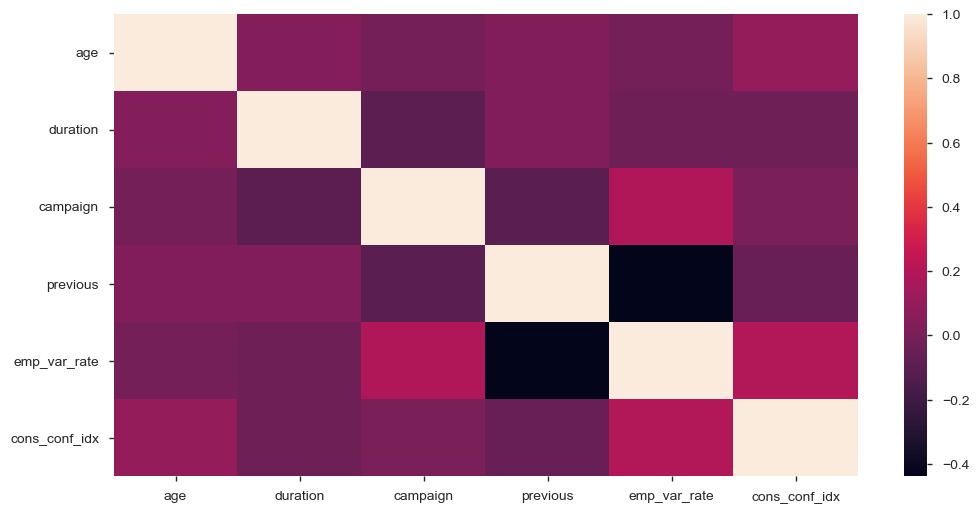

In [22]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(data_num.corr())
plt.show()

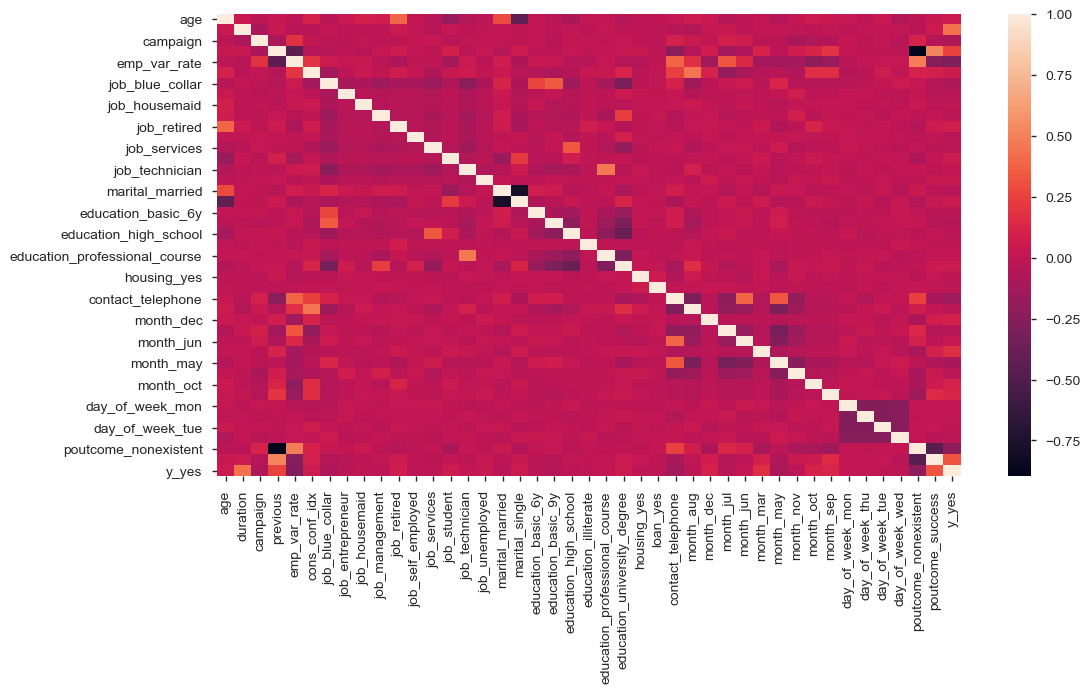

In [23]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize=(12,6))
sns.heatmap(data_new.corr())
plt.show()

### variable reduction (feature selection/reduction)

- Variable reduction using Somerce D values
- WOE - Binomial classification
- RFE
- SelectKBest
- VIF
- PCA

#### Variable reduction using Somerce D values

In [24]:
somersd_df = pd.DataFrame()
for i in data_new.columns.difference(['y_yes']):
    result = smf.logit(formula = str('y_yes ~')+str(i), data = data_new).fit()
    somers_d = 2*metrics.roc_auc_score(data_new.y_yes, result.predict()) -1
    temp = pd.DataFrame([i, somers_d]).T
    temp.columns = ['VariableName', 'SomersD']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.344178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334952
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345048
  

In [25]:
somersd_df.sort_values('SomersD', ascending=False).head(15)

,VariableName,SomersD
0,duration,0.643665
0,emp_var_rate,0.412654
0,previous,0.243887
0,poutcome_nonexistent,0.233411
0,contact_telephone,0.210711
0,poutcome_success,0.19036
0,month_may,0.151588
0,campaign,0.107061
0,job_blue_collar,0.089118
0,cons_conf_idx,0.0857412


### RFE

In [26]:
X = data_new[data_new.columns.difference(['y_yes'])]
classifier = RandomForestClassifier()
rfe = RFE(classifier, 15)
rfe = rfe.fit(X, data_new[['y_yes']] )

C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
list(X.columns[rfe.support_])

['age',
 'campaign',
 'cons_conf_idx',
 'contact_telephone',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'duration',
 'education_university_degree',
 'emp_var_rate',
 'housing_yes',
 'job_technician',
 'marital_married',
 'poutcome_success',
 'previous']

#### Select KBEST

In [28]:
X = data_new[data_new.columns.difference(['y_yes'])]
SKB = SelectKBest(f_classif, k=15).fit(X, data_new[['y_yes']] )

C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
list(X.columns[SKB.get_support()])

['campaign',
 'contact_telephone',
 'duration',
 'education_university_degree',
 'emp_var_rate',
 'job_blue_collar',
 'job_retired',
 'month_dec',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_nonexistent',
 'poutcome_success',
 'previous']

Finalize the List (from Univariate(somerce D), RFE, SelectKbest) and choose best 15 variable.

In [30]:
final_list = ['job_blue_collar',
 'job_retired',
 'emp_var_rate',
 'cons_conf_idx',
 'month_dec',
 'loan_yes',
 'contact_telephone',
 'previous',
 'poutcome_nonexistent',
 'campaign',
 'month_sep',
 'month_mar',
 'job_technician',
 'day_of_week_mon',
 'day_of_week_tue',
 'housing_yes',
 'education_basic_9y',
 'duration',
 'marital_married',
 'poutcome_success',
 'age',
 'marital_single',
 'month_oct',
 'month_may',
 'education_university_degree']

In [31]:
X = data_new[final_list]
X.head()

,job_blue_collar,job_retired,emp_var_rate,cons_conf_idx,month_dec,loan_yes,contact_telephone,previous,poutcome_nonexistent,campaign,...,housing_yes,education_basic_9y,duration,marital_married,poutcome_success,age,marital_single,month_oct,month_may,education_university_degree
0,1,0,-1.8,-46.2,0,0,0,0,1,2,...,1,1,487.0,1,0,30,0,0,1,0
1,0,0,1.1,-36.4,0,0,1,0,1,4,...,0,0,346.0,0,0,39,1,0,1,0
2,0,0,1.4,-41.8,0,0,1,0,1,1,...,1,0,227.0,1,0,25,0,0,0,0
3,0,0,1.4,-41.8,0,0,1,0,1,3,...,1,1,17.0,1,0,38,0,0,0,0
4,0,0,-0.1,-42.0,0,0,0,0,1,1,...,1,0,58.0,1,0,47,0,0,0,1


#### Using WOE (Weight of Evidence)
- Identify important variables using WOE or log(odds) comparing with Y
- Variable Transformation: (i) Bucketing if the variables are not having linear relationship with log(odds)

In [55]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [56]:
for col in data_new.columns:
    if col == 'y_yes': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(data_new, col, 'y_yes')
       # print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: age
IV score: 0.30


WoE and IV for column: duration


C:\Users\Shyamprasath\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


IV score: 0.76


WoE and IV for column: campaign
IV score: 0.08


WoE and IV for column: previous
IV score: 0.42


WoE and IV for column: emp_var_rate
IV score: 1.04


WoE and IV for column: cons_conf_idx
IV score: 1.34


WoE and IV for column: job_blue_collar
IV score: 0.05


WoE and IV for column: job_entrepreneur
IV score: 0.02


WoE and IV for column: job_housemaid
IV score: 0.00


WoE and IV for column: job_management
IV score: 0.00


WoE and IV for column: job_retired
IV score: 0.05


WoE and IV for column: job_self_employed
IV score: 0.00


WoE and IV for column: job_services
IV score: 0.01


WoE and IV for column: job_student
IV score: 0.02


WoE and IV for column: job_technician
IV score: 0.00


WoE and IV for column: job_unemployed
IV score: 0.01


WoE and IV for column: marital_married
IV score: 0.01


WoE and IV for column: marital_single
IV score: 0.02


WoE and IV for column: education_basic_6y
IV score: 0.01


WoE and IV for column: education_basic_9y
IV score: 0.02


Wo

 You can select the variables based on the information value and below criteria
 
 - IV: <0.02, Predictive Power: Useless for prediction
 - IV: 0.02 - 0.1, Predictive Power: Weak predictor
 - IV: 0.1 - 0.2, Predictive Power: Medium predictor
 - IV: 0.3 - 0.5, Predictive Power: Storng predictor
 - IV: > 0.5, Predictive Power: Suspecious predictor or too good predictor

#### VIF Variance Inflation Factor

In [59]:
# X_new =  X
X_new =  X[X.columns.difference(['cons_conf_idx', 'age', 'poutcome_nonexistent'])]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

print(vif)

    VIF Factor                     features
0     2.150312                     campaign
1     2.277508            contact_telephone
2     1.321065              day_of_week_mon
3     1.322470              day_of_week_tue
4     2.042340                     duration
5     1.368387           education_basic_9y
6     1.726249  education_university_degree
7     1.767815                 emp_var_rate
8     2.092939                  housing_yes
9     1.643026              job_blue_collar
10    1.108688                  job_retired
11    1.278982               job_technician
12    1.185199                     loan_yes
13    3.777313              marital_married
14    2.280458               marital_single
15    1.047464                    month_dec
16    1.059815                    month_mar
17    2.004183                    month_may
18    1.125522                    month_oct
19    1.107906                    month_sep
20    1.432171             poutcome_success
21    1.797200                  

### Splitting the data into train & test 

In [60]:
target = data_new[['y_yes']]
features = X_new

In [61]:
#Splitting the data for sklearn methods
train_y, test_y, train_X, test_X = train_test_split(target,features, test_size=0.3, random_state=123)

## Random Forest

In [63]:
random_clf = RandomForestClassifier(n_estimators=100, oob_score = True, max_features=6, n_jobs=-1)
random_clf.fit(train_X, train_y)

C:\Users\Shyamprasath\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [89]:
print(metrics.classification_report(train_y, random_clf.predict(train_X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2576
           1       1.00      1.00      1.00       307

    accuracy                           1.00      2883
   macro avg       1.00      1.00      1.00      2883
weighted avg       1.00      1.00      1.00      2883



In [96]:
print(metrics.classification_report(test_y, random_clf.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1092
           1       0.65      0.43      0.52       144

    accuracy                           0.91      1236
   macro avg       0.79      0.70      0.73      1236
weighted avg       0.90      0.91      0.90      1236



### Feature importance from the Random Forest Model

In [83]:
fea_imp = pd.DataFrame()
fea_imp['importance'] = random_clf.feature_importances_
fea_imp['features'] = train_X.columns
fea_imp.sort_values(by = ['importance'], ascending = False, inplace = True)

<AxesSubplot:xlabel='importance', ylabel='features'>

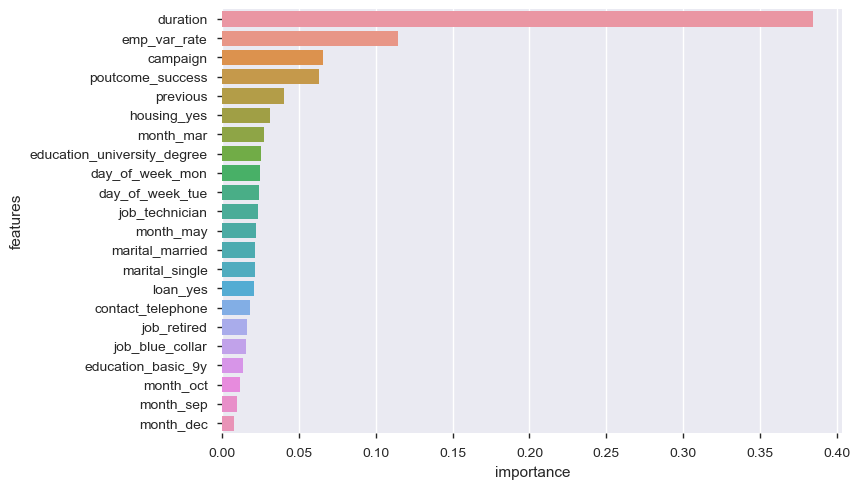

In [84]:
sns.barplot(y = 'features', x = 'importance', data = fea_imp)

### Tuning parameters

In [93]:
pargrid_ada = {'n_estimators': [70, 80, 90, 100, 110, 120],
                'max_features': [5,6,7,8,9,10,11,12]}
gscv_Rf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=pargrid_ada, 
                        cv=5,
                        verbose=True, n_jobs=-1)

In [94]:
gscv_results = gscv_Rf.fit(train_X, train_y)
gscv_results.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished
C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.914325775081841

In [95]:
gscv_results.best_params_

{'max_features': 7, 'n_estimators': 90}

### XGBOOST

In [98]:
xgb_estimator = XGBClassifier(n_estimators=200,
                         random_state = 42,
                        n_jobs=-1,
                        verbose=1)

In [99]:
xgb_estimator.fit(train_X, train_y)

C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[20:37:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

In [104]:
print(metrics.roc_auc_score(train_y,xgb_estimator.predict(train_X)))

1.0


In [105]:
print(metrics.classification_report(train_y, xgb_estimator.predict(train_X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2576
           1       1.00      1.00      1.00       307

    accuracy                           1.00      2883
   macro avg       1.00      1.00      1.00      2883
weighted avg       1.00      1.00      1.00      2883



In [106]:
print(metrics.classification_report(test_y, xgb_estimator.predict(test_X)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1092
           1       0.58      0.49      0.53       144

    accuracy                           0.90      1236
   macro avg       0.76      0.72      0.74      1236
weighted avg       0.89      0.90      0.90      1236



### Gridsearchcv

In [108]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [110]:
xgb = GridSearchCV(estimator=XGBClassifier(), 
                        param_grid=params, 
                        cv=5,
                        verbose=True, n_jobs=-1)
xgb.fit(train_X, train_y)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed:  5.9min finished
C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Shyamprasath\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='deprecated', n_jobs=-1,
             

In [111]:
print(metrics.classification_report(train_y, xgb.predict(train_X)))
print(metrics.classification_report(test_y, xgb.predict(test_X)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2576
           1       0.77      0.61      0.68       307

    accuracy                           0.94      2883
   macro avg       0.86      0.79      0.82      2883
weighted avg       0.93      0.94      0.94      2883

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1092
           1       0.64      0.44      0.52       144

    accuracy                           0.91      1236
   macro avg       0.78      0.71      0.74      1236
weighted avg       0.90      0.91      0.90      1236



## Saving as pickle object

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb_estimator, f)